# L'algoritmo CYK


In [ ]:
from itertools import count

from liblet import (
  Tree, Grammar, Production, Derivation, ProductionGraph, CYKTable, closure, union_of, ε
)

## La tabella `R` e la sua relazione con l'input

In [ ]:
INPUT = 'unaprova'

n = len(INPUT)

R = CYKTable()
for l in range(1, n + 1):
  for i in range(1, n - l + 2): 
    R[i, l] = INPUT[(i) - 1: (i + l) - 1]

R

## Due modi per riempire la tabella…

Supponendo di avere la funzione `fill(R, i, l)` che restituisce il valore di `R[(i, l)`.

In [ ]:
def offline(fill, n):
  R = CYKTable()
  for l in range(1, n + 1):
    for i in range(1, n - l + 2): 
      R[i, l] = fill(R, i, l)
  return R

In [ ]:
def online(fill, n):
  R = CYKTable()
  for d in range(1, n + 1):
    for i in range(d, 0, -1):
      R[i, d - i + 1] = fill(R, i, d - i + 1)
  return R

La seguente funzione `make_counter_fill` restituisce una funzione `fill` che, ignorando i parametri, restituisce un numero progressivo (usando `count` del modulo `itertools`).

In [ ]:
def make_counter_fill():
  cnt = count(1)
  def fill(R, i, l):
    return next(cnt)
  return fill

Usando `offline` e `online` con il contatore si visualizza l'ordine di riempimento

In [ ]:
offline(make_counter_fill(), 5)

In [ ]:
online(make_counter_fill(), 5)

## Filtrare le produzioni coi predicati

Usando la funzione *builtin* `filter` e un *predicato*  si può ottenere un sottoiteratore.

In [ ]:
def pari(x):
  return x % 2 == 0

list(filter(pari, range(10)))

[0, 2, 4, 6, 8]

Vediamo due predicati per le produzioni…

In [ ]:
prods = Production.from_string("""
A -> a
A -> B C
""")

In [ ]:
# quelle con rhs lungo 2

list(filter(Production.such_that(rhs_len = 2), prods))

[A -> B C]

In [ ]:
# e quelle con rhs lungo 1

list(filter(Production.such_that(rhs_len = 1), prods))

[A -> a]

## Il riempimento dell'algoritmo CYK nel caso CNF

Supponiamo che la grammatica sia in *Chomsky Normal Form*, ovvero le produzioni abbiano la forma $A\to BC$ o $A\to a$ (senza ε-regole).

In [ ]:
def cyk_fill(G, INPUT):
  def fill(R, i, l):
    res = set()
    if l == 1:
      for A, (a,) in filter(Production.such_that(rhs_len = 1), G.P): 
        if a == INPUT[i - 1]: res.add(A)
    else:
      for k in range(1, l):
        for A, (B, C) in filter(Production.such_that(rhs_len = 2), G.P):
          if B in R[i, k] and C in R[i + k, l - k]: res.add(A)
    return res
  return fill

Qualche esempio su una grammatica per `a`$^n$`.`

In [ ]:
G = Grammar.from_string("""
S -> A S
A -> a
S -> .
""")

In [ ]:
INPUT = 'aaa.'

online(cyk_fill(G, INPUT), len(INPUT))

In [ ]:
INPUT = 'aa.a.'

online(cyk_fill(G, INPUT), len(INPUT))

Una grammatica più complessa (per i numeri decimali con virgola, in notazione scientifica)

In [ ]:
# fig. 4.15, pag. 123 

G = Grammar.from_string("""
Number -> 0|1|2|3|4|5|6|7|8|9 
Number -> Integer Digit
Number -> N1 Scale' | Integer Fraction
N1 -> Integer Fraction
Integer -> 0|1|2|3|4|5|6|7|8|9 
Integer -> Integer Digit
Fraction -> T1 Integer
T1 -> .
Scale' -> N2 Integer
N2 -> T2 Sign
T2 -> e
Digit -> 0|1|2|3|4|5|6|7|8|9 
Sign -> + | -
""")

In [ ]:
# per comodità

def cyk(G, INPUT):
  return offline(cyk_fill(G, INPUT), len(INPUT))

In [ ]:
INPUT = '32.5e+1'

R = cyk(G, INPUT)
R

## Generare l'albero di parsing (barando)

La tabella contiene non terminali e, in accordo al criterio usato per riempirla, tali non terminali possono essere raccolti in un albero che ha l'aspetto di un albero di derivazione — anche se costruito senza riferimento alle produzioni (dal quale non è quindi banale ricostruire la derivazione).

Scriviamo una funzione ricorsiva `fake_parse` che (usando tabella `R`, la grammatica `G` e l'input `INPUT`) dato un non terminale, il punto d'inizio e la lunghezza, restituisca l'albero di parsing radicato in quel non terminale e che deriva la sottostringa specificata.

In [ ]:
def fake_parse(X, i, l):
  if l == 1: return Tree(X, [Tree(INPUT[i-1])])
  for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
    for k in range(1, l):
      if B in R[i, k] and C in R[i + k, l - k]:
        return Tree(A, [fake_parse(B, i, k), fake_parse(C, i + k, l - k)])

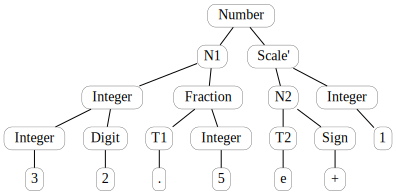

In [ ]:
fake_parse(G.S, 1, len(INPUT))

## Trasformazione in forma normale di Chomsky

Recuperiamo dalla lezione 3 come eliminare le regole improduttive e irraggiungibili.

In [ ]:
def remove_unproductive_unreachable(G):
  def find_productive(G):
    @closure
    def find(prod):
      return prod | {A for A, α in G.P if set(α) <= prod}
    return find(G.T)
  def find_reachable(G):
    @closure
    def find(reach):
      return reach | union_of(set(α) for A, α in G.P if A in reach)
    return find({G.S})
  Gp = G.restrict_to(find_productive(G))
  return Gp.restrict_to(find_reachable(Gp))

### Eliminazione ε-regole (Sez. 4.2.3.1)

Due passi, ottenuti tramite *chiusura*, consentono di rimpiazzare un simbolo nei lati destri con `replace_in_rhs` e quindi applicare il primo passo a tutti i simboli che compaiono in una ε-regola con `inline_ε_rules`.

In [ ]:
@closure
def replace_in_rhs(G, A):
  Ap = A + '′'
  prods = set()
  for B, β in G.P:
    if A in β:
      pos = β.index(A)
      rhs = β[:pos] + β[pos + 1:]
      if len(rhs) == 0: rhs = (ε, )
      prods.add(Production(B, rhs))
      prods.add(Production(B, β[:pos] + (Ap, ) + β[pos + 1:]))
    else:
      prods.add(Production(B, β))
  return Grammar(G.N | {Ap}, G.T, prods, G.S)

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> x A y A z
A -> a
""")
replace_in_rhs(U, 'A').P

(S -> x A′ y z, S -> x A′ y A′ z, A -> a, S -> x y A′ z, S -> x y z)

In [ ]:
@closure
def inline_ε_rules(G_seen):
  G, seen = G_seen
  for A in G.N - seen:
    if (ε, ) in G.alternatives(A):
      return replace_in_rhs(G, A), seen | {A}
  return G, seen

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> A
A -> B C
B -> ε
C -> ε
""")
U, _ = inline_ε_rules((U, set()))

U.P

(A -> B′ C′, S -> A′, A -> B′, S -> ε, C -> ε, A -> ε, A -> C′, B -> ε)

Usando i due passi precedenti è semplice scrivere il passo di eliminazione

In [ ]:
def eliminate_ε_rules(G):
  Gp, _ = inline_ε_rules((G, set()))
  prods = set(Gp.P)
  for Ap in Gp.N - G.N:
    A = Ap[:-1]
    for α in set(Gp.alternatives(A)) - {(ε, )}:
      prods.add(Production(Ap, α))
  return Grammar(Gp.N, Gp.T, prods, Gp.S)

In [ ]:
# esempio d'uso (fig. 4.10, pag. 120)

U = Grammar.from_string("""
S -> L a M
L -> L M 
L -> ε
M -> M M
M -> ε
""")

eliminate_ε_rules(U).P

(L -> ε,
 L′ -> M′,
 L -> L′ M′,
 S -> a M′,
 S -> L′ a M′,
 M -> M′ M′,
 L′ -> L′,
 L -> M′,
 M -> ε,
 M′ -> M′ M′,
 L′ -> L′ M′,
 M′ -> M′,
 S -> a,
 L -> L′,
 M -> M′,
 S -> L′ a)

### Eliminazione regole unitarie (Sez. 4.2.3.2)

In [ ]:
def eliminate_unit_rules(G):
  @closure
  def eliminate(G_seen):
    G, seen = G_seen
    for P in set(filter(Production.such_that(rhs_len = 1), G.P)) - seen:
      A, (B, ) = P
      if B in G.N:
        prods = (set(G.P) | {Production(A, α) for α in G.alternatives(B)}) - {P}
        return Grammar(G.N, G.T, prods, G.S), seen | {P}
    return G, seen
  return eliminate((G, set()))[0]

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> A
A -> B
B -> A | b
""")

eliminate_unit_rules(U).P

(A -> b, S -> b, B -> b)

#### Un esempio più elaborato

In [ ]:
# fig. 4.6, pag. 112

G = Grammar.from_string("""
Number -> Integer | Real
Integer -> Digit | Integer Digit
Real -> Integer Fraction Scale
Fraction -> . Integer
Scale -> e Sign Integer | Empty
Digit -> 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
Sign -> + | -
Empty -> ε
""")

In [ ]:
# fig. 4.12, pag. 120 (a meno di Empty′)

eliminate_ε_rules(G).P

(Digit -> 0,
 Empty -> ε,
 Integer -> Digit,
 Scale′ -> Empty′,
 Number -> Real,
 Digit -> 5,
 Number -> Integer,
 Digit -> 9,
 Sign -> +,
 Digit -> 6,
 Scale′ -> e Sign Integer,
 Digit -> 3,
 Scale -> Empty′,
 Real -> Integer Fraction,
 Sign -> -,
 Digit -> 2,
 Digit -> 8,
 Digit -> 4,
 Digit -> 7,
 Fraction -> . Integer,
 Integer -> Integer Digit,
 Scale -> e Sign Integer,
 Scale -> ε,
 Real -> Integer Fraction Scale′,
 Digit -> 1)

Data la `G` per i numeri con la virgola, si ottiene `Gp` coi primi due passi di cui sopra.

In [ ]:
# fig. 4.13, pag. 121

Gp = eliminate_unit_rules(eliminate_ε_rules(G))
Gp.P

(Digit -> 0,
 Empty -> ε,
 Integer -> 5,
 Integer -> 9,
 Number -> Integer Fraction Scale′,
 Integer -> 6,
 Number -> Integer Digit,
 Digit -> 5,
 Digit -> 9,
 Integer -> 3,
 Number -> 0,
 Sign -> +,
 Digit -> 6,
 Number -> 1,
 Scale′ -> e Sign Integer,
 Digit -> 3,
 Integer -> 2,
 Number -> 5,
 Real -> Integer Fraction,
 Integer -> 8,
 Integer -> 4,
 Sign -> -,
 Integer -> 7,
 Digit -> 2,
 Digit -> 8,
 Number -> 9,
 Digit -> 4,
 Digit -> 7,
 Number -> 6,
 Number -> Integer Fraction,
 Fraction -> . Integer,
 Integer -> Integer Digit,
 Number -> 3,
 Scale -> e Sign Integer,
 Scale -> ε,
 Integer -> 0,
 Integer -> 1,
 Number -> 7,
 Real -> Integer Fraction Scale′,
 Number -> 4,
 Number -> 2,
 Digit -> 1,
 Number -> 8)

### Eliminare regole/simboli non produttive e  non raggiungibili (Sez. 2.9.5.1-2)

In [ ]:
# fig. 4.14, pag. 122

Gp_clean = remove_unproductive_unreachable(Gp)
Gp_clean.P

(Digit -> 0,
 Integer -> 5,
 Integer -> 9,
 Number -> Integer Fraction Scale′,
 Integer -> 6,
 Number -> Integer Digit,
 Digit -> 5,
 Digit -> 9,
 Integer -> 3,
 Number -> 0,
 Sign -> +,
 Digit -> 6,
 Number -> 1,
 Scale′ -> e Sign Integer,
 Digit -> 3,
 Integer -> 2,
 Number -> 5,
 Integer -> 8,
 Integer -> 4,
 Sign -> -,
 Integer -> 7,
 Digit -> 2,
 Digit -> 8,
 Number -> 9,
 Digit -> 4,
 Digit -> 7,
 Number -> 6,
 Number -> Integer Fraction,
 Fraction -> . Integer,
 Integer -> Integer Digit,
 Number -> 3,
 Integer -> 0,
 Integer -> 1,
 Number -> 7,
 Number -> 4,
 Number -> 2,
 Digit -> 1,
 Number -> 8)

### Riduzione in forma normale (Sez. 4.3.2.4)

#### Caso $A\to \alpha a \beta$

In [ ]:
def transform_nonsolitary(G):
  prods = set()
  for A, α in G.P:
    prods.add(Production(A, [f'N{x}' if x in G.T else x for x in α] if len(α) > 1 else α))
    prods |= {Production(f'N{x}', (x, )) for x in α if x in G.T and len(α) > 1}
  return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> x S y S x
""")

transform_nonsolitary(U).P

(Ny -> y, Nx -> x, S -> Nx S Ny S Nx)

#### Caso $A\to X_1 X_2\ldots X_n$

In [ ]:
def make_binary(G):
  prods = set()
  for A, α in G.P:
    if len(α) > 2:
      Ai = f'{A}{1}'
      prods.add(Production(Ai, α[:2]))
      for i, Xi in enumerate(α[2:-1], 2):
          prods.add(Production(f'{A}{i}', (Ai, Xi)))
          Ai = f'{A}{i}'
      prods.add(Production(A, (Ai, α[-1])))
    else:
      prods.add(Production(A, α))
  return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> A B C D
""")

make_binary(U).P

(S2 -> S1 C, S -> S2 D, S1 -> A B)

#### Di nuovo, l'esempio più elaborato

In [ ]:
# fig. 4.15, pag. 123 (rinominando alcuni non terminali)

G_cnf = make_binary(transform_nonsolitary(Gp_clean))
G_cnf.P

(Digit -> 0,
 Integer -> 5,
 Integer -> 9,
 Integer -> 6,
 Number -> Integer Digit,
 Digit -> 5,
 Digit -> 9,
 Integer -> 3,
 Number -> Number1 Scale′,
 Number -> 0,
 Sign -> +,
 Digit -> 6,
 Number -> 1,
 Number1 -> Integer Fraction,
 Digit -> 3,
 Scale′ -> Scale′1 Integer,
 Integer -> 2,
 Number -> 5,
 Integer -> 8,
 Integer -> 4,
 Sign -> -,
 Integer -> 7,
 N. -> .,
 Digit -> 2,
 Fraction -> N. Integer,
 Digit -> 8,
 Ne -> e,
 Number -> 9,
 Digit -> 4,
 Digit -> 7,
 Number -> 6,
 Number -> Integer Fraction,
 Integer -> Integer Digit,
 Scale′1 -> Ne Sign,
 Number -> 3,
 Integer -> 0,
 Integer -> 1,
 Number -> 7,
 Number -> 4,
 Number -> 2,
 Digit -> 1,
 Number -> 8)